# COGS 108 - Final Project 

# Overview

kickstarter website
- what is it? when is it established by who? how do people utiilize it?
- what helps for/ what is it helpful to our life?
- why we chose this


# Names

- Karen Rodriguez Pinto
- Enlin Wei
- Yumi Minami 
- Kanami Hannah Tanaka
- Alan Lloyd Willey

# Group Members IDs

- A15161856
- A12938737
- A12669124
- A14714448
- A15746309

# Research Question

**In US-based kickstarter projects only, to control for variations that may have been due to kickstarters being from different contries**

successful vs failed funding; which factor correlates the most to the funding result?

which category is the most successful
which category is the least successful
is the bigger city, the better at funding?

which year was the most successful? -> we can talk abouut why this yera was the most successful; economic impact

the correlation between the excessive amount (like usd_pledged minus their own goal) and 

which quarter is the most effctive or active for funding for each category?

does the name length affect to the funding outcome? 


*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


music and films are famous for any age ranges, generations, and gender


*Fill in your hypotheses here*

# Dataset(s)

- Dataset Name: Kickstarter Campaigns
- Link to the dataset: https://www.kaggle.com/yashkantharia/kickstarter-campaigns
- Number of observations: 192548

This dataset contains information about Kickstarter crowdfunding campaigns from 2014 to February 2019. The information includes the names, currency, main and subcategories, launch date and deadlines, goal amount of money to raise and actual amounts raised, whether the campaign was successful or failed, and geographical locations of the campaigns (country and state).

# Setup

In [1]:
# imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import datetime as dt

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# loads Kickstarters data into dataframe
df_kickstarters = pd.read_csv("Kickstarter_projects_Feb19.csv")

In [3]:
# viewing the first rows of the dataframe
df_kickstarters.head()

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


# Data Cleaning

We will first take the subset of US-based kickstarters only.

In [4]:
df_kickstarters = df_kickstarters[df_kickstarters['country']=='US']

We checked to see that the country and the currency are both US-only after the drop.

In [5]:
df_kickstarters.country.unique()

array(['US'], dtype=object)

In [6]:
df_kickstarters.currency.unique()

array(['USD'], dtype=object)

We then checked to see if any cell has null values, and if so to drop those entries.

In [7]:
df_kickstarters[df_kickstarters.isnull().any(axis=1)]

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged


We found no null values in the dataset, and so we proceeded with data cleaning.

We first dropped the column 'id' since it gives no useful information, just an ID associated with the project. We then dropped columns 'start_month' and 'end_month' since the information about the start and end months of the projects are already given in the dates in the 'launched_at' and 'deadline' columns and so is redundant. We checked to see that the country and currency are all US-based, so it would not be necessary to keep those columns.

In [8]:
df_kickstarters.drop(columns=['id', 'start_month', 'end_month', 'country', 'currency'], inplace=True)

We then noticed that the **launched_at** and **deadline** columns contained dates and times of when the projects were launched and ended in string format. It would be easier to work with datetime objects, so we replaced the strings with datetime objects.

In [9]:
# method to convert datetime strings in 'df_kickstarters' into datetime objects
def to_datetime(datetime_str):
    return dt.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

In [10]:
# converts all datetime strings in df to datetime objects
df_kickstarters['launched_at'] = df_kickstarters['launched_at'].apply(to_datetime)
df_kickstarters['deadline'] = df_kickstarters['deadline'].apply(to_datetime)

Finally, we noticed some of the monetary amounts have more than 2 decimal places, which should be cleaned up since we don't work with monetary amounts more specific than 2 decimal places. So we decided to round the amounts to 2 decimal places.

In [11]:
df_kickstarters['goal_usd'] = df_kickstarters['goal_usd'].round(2)
df_kickstarters['usd_pledged'] = df_kickstarters['usd_pledged'].round(2)

# Data Analysis & Results

Since our project aims to analyze which factor is most important for the success of kickstarters, we will divide the dataframe into two separate ones, one with all the successful projects and one with all the failed projects.

In [12]:
# divides df_kickstarters into successful and failed ones
df_successful = df_kickstarters[df_kickstarters['status']=='successful']
df_failed = df_kickstarters[df_kickstarters['status']=='failed']

In [13]:
# views number of successful and failed kickstarters
print("Number of successful kickstarters: " + str(len(df_successful))); print("Number of failed kickstarters: " + str(len(df_failed)))

Number of successful kickstarters: 85473
Number of failed kickstarters: 52372


It seems that there are different numbers of successful and failed kickstarters; we will account for that by comparing the ratio of each category in the successful versus failed kickstarters.

"\nf = plt.figure();\ndf2 = df.groupby([ 'lecture_attendance','gender'])['lecture_attendance'].count().unstack('gender').fillna(0)\nsub_df2 = np.transpose(df2.div(df2.sum()))\nsub_df2.plot(kind='bar', stacked=True, rot=0)\n"

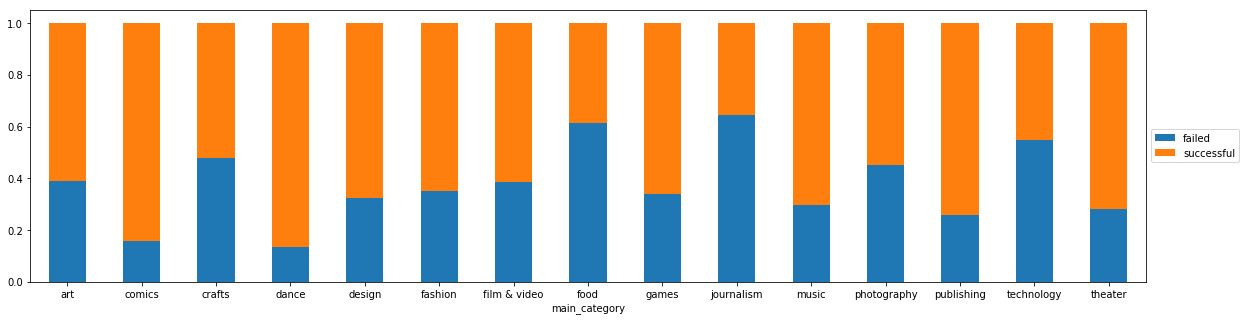

In [14]:
df_categories = df_kickstarters.groupby(['status','main_category'])['status'].count().unstack('main_category').fillna(0)
sub_df_categories = np.transpose(df_categories.div(df_categories.sum()))
sub_df_categories.plot(kind='bar',stacked=True,rot=0, figsize=(20,5))

plt.legend(('failed','successful'), loc='center left', bbox_to_anchor=(1.0, 0.5))

"""
f = plt.figure();
df2 = df.groupby([ 'lecture_attendance','gender'])['lecture_attendance'].count().unstack('gender').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))
sub_df2.plot(kind='bar', stacked=True, rot=0)
"""

## anyone know how to make this plot bigger?

In [15]:
# views first rows of df_kickstarters
df_kickstarters.head()

,name,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,blurb_length,name_length,status,start_Q,end_Q,usd_pledged
0,Socks of Speed and Socks of Elvenkind,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.0,Menasha,WI,14,7,successful,Q4,Q4,6061.0
2,"Live Printing with SX8: ""Squeegee Pulp Up""",fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.0,Manhattan,NY,21,7,successful,Q2,Q3,1110.0
3,Lost Dog Street Band's Next Album,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.0,Nashville,TN,15,6,successful,Q3,Q4,4807.0
4,"Qto-X, a Tiny Lantern",technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.0,Troy,MI,15,4,successful,Q4,Q1,40368.0
5,"Aaron McDonnell EP ""Follow""",music,Country & Folk,2014-01-22 18:21:37,2014-02-21 18:21:37,30.0,7500.0,Seattle,WA,11,4,successful,Q1,Q1,7770.0


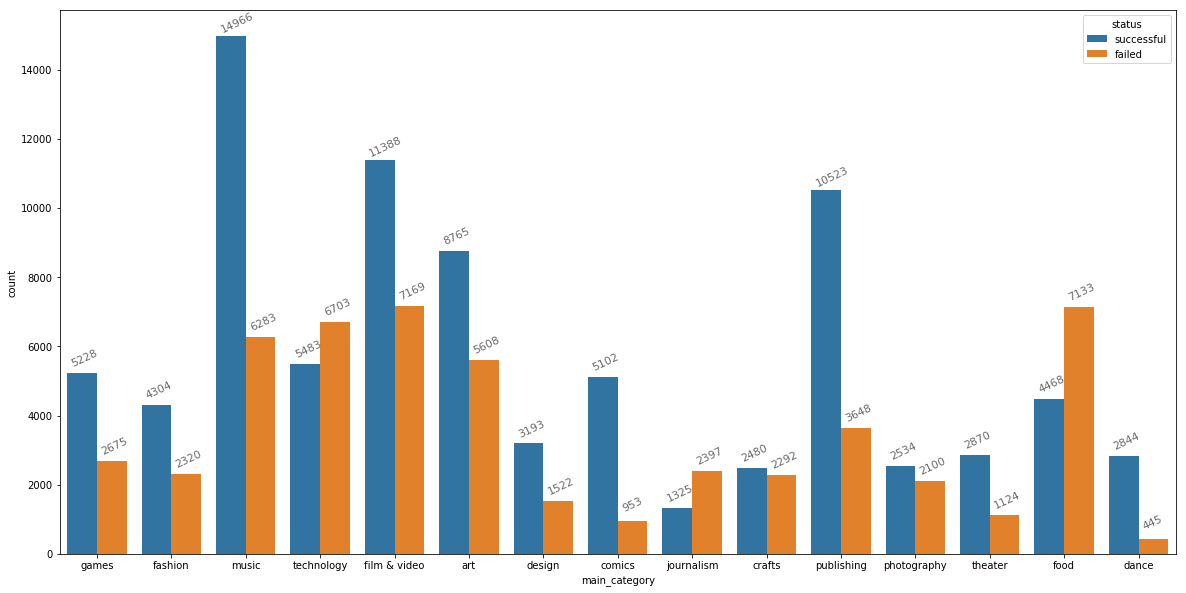

In [48]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='main_category',hue='status',data=df_kickstarters)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+500, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey', rotation=25)

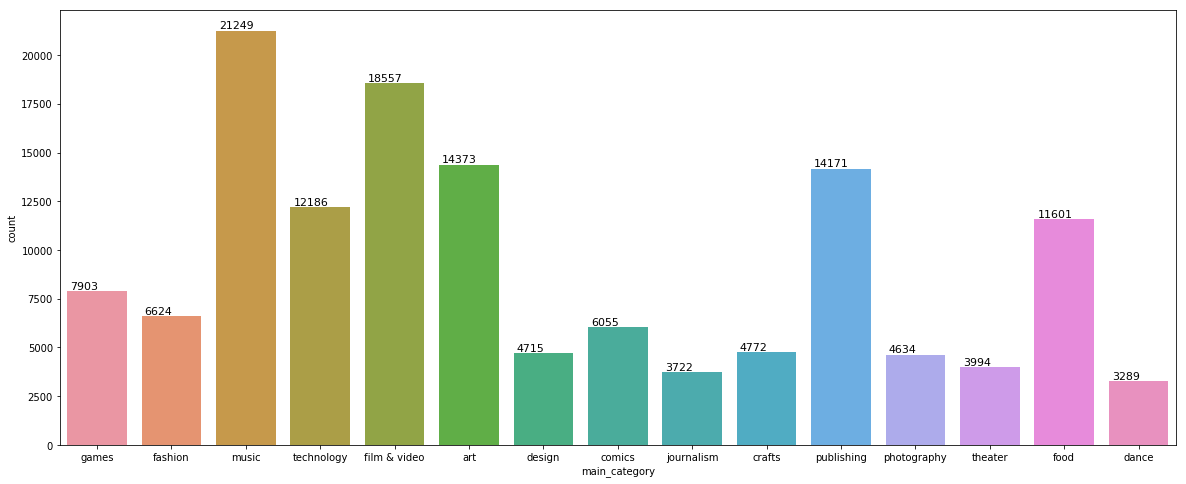

In [54]:
plt.figure(figsize=(20,8))
axPlt = sns.countplot(x='main_category',data=df_kickstarters)

for i in axPlt.patches:
    # get_x pulls left or right; get_height pushes up or down
    axPlt.text(i.get_x()+.14, i.get_height()+100, \
            str(round((i.get_height()), 2)), fontsize=11)

In [18]:
outcome,predictors = patsy.dmatrices('status ~ main_category',df_kickstarters)
mod = sm.OLS(outcome,predictors)
res = mod.fit()

In [21]:
# this is throwing a "not aligned" error
res.sum()

AttributeError: 'OLSResults' object has no attribute 'sum'

In [ ]:
df_kickstarters.boxplot(column=['duration'],by='status',showfliers=False)

In [22]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*